# PriorCVAE on Lotka Volterra

In [2]:
import random as rnd

import numpy as np 
import matplotlib.pyplot as plt
import flax.linen as nn

import numpyro
from numpyro.diagnostics import hpdi
numpyro.set_host_device_count(4)

import jax
import optax
from jax import random
import jax.numpy as jnp

from priorCVAE_copy.models import CNNEncoder, CNNDecoder, VAE
from priorCVAE_copy.datasets import LVDataset
from priorCVAE_copy.trainer import VAETrainer
from priorCVAE_copy.losses import SquaredSumAndKL, SumPixelAndKL

import jax.config as config
config.update("jax_enable_x64", True)

In [2]:
import pints
import pints_jax
import pints.toy as toy
import pints.toy.stochastic
import pints.plot

In [26]:
args = {
        "conditional": True,
        
        # architecture
        "input_dim" : 80,
        "hidden_dim": 60,
        "latent_dim": 40,
        
        # VAE training    
        "batch_size": 1,
        "num_iterations": 3000,
        "learning_rate": 1e-3,
        "vae_var": 1.,

        # MCMC inference
        "true_ls": 0.2,
        "num_warmup": 1000,
        "num_mcmc_samples": 4000,
        "num_chains": 4,
        "thinning": 1,
       }

## Generate Data
**Problem:** how can we get a general enough data set, including different initial population densities and parameters?   
Parameters are easier to generate, uniform priors will be fine. What about initial population densities? What are common initial circumstances for the Lotka Volterra model? What are considered as general?

In [3]:
generator = LVDataset()
time_train, xy_train, params_train = generator.simulatedata(1000)
time_test, xy_test, params_test = generator.simulatedata(1000)

In [3]:
new_xy_train = jnp.nan_to_num(xy_train,copy=True, nan=0, posinf=1e6, neginf=-1e6)
new_xy_train = np.where(new_xy_train<1e6, new_xy_train, 1e6)
new_xy_train = np.where(new_xy_train>-1e6, new_xy_train, -1e6)

In [14]:
jnp.max(params_train)

Array(1.99943967, dtype=float64)

In [5]:
new_xy_test = jnp.nan_to_num(xy_test,copy=True, nan=0, posinf=1e6, neginf=-1e6)
new_xy_test = np.where(new_xy_test<1e6, new_xy_test, 1e6)
new_xy_test = np.where(new_xy_test>-1e6, new_xy_test, -1e6)

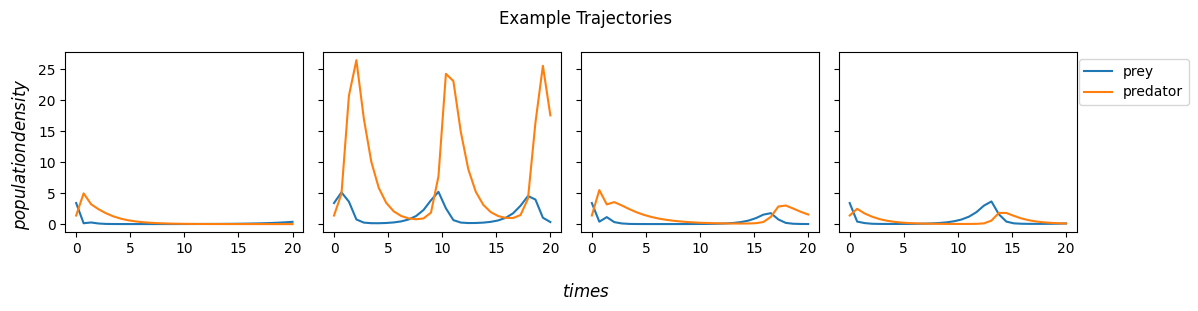

In [4]:
fig, axs = plt.subplots(1,4, sharex=True, sharey=True, figsize=(12,3))
for i in range(4):
    axs[i].plot(time_train[i], xy_train[i,:,0,:],label='prey')
    axs[i].plot(time_train[i], xy_train[i][:,1,:], label='predator')
plt.suptitle('Example Trajectories')
fig.supxlabel('$times$')
fig.supylabel('$population density$')
labels = ['prey', 'predator']
plt.legend(labels, loc='best', bbox_to_anchor=(1.5, 1))
plt.tight_layout()
plt.show()

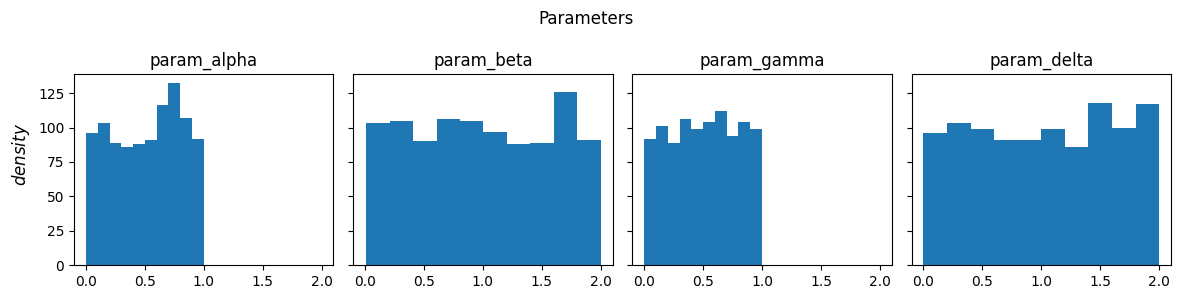

In [24]:
fig, axs = plt.subplots(1,4, sharex=True, sharey=True, figsize=(12,3))
for i in range(4):
    axs[i].hist(params_test[:,0,0,i])
    args = ['param_alpha','param_beta','param_gamma','param_delta']
    axs[i].set_title(args[i])
plt.suptitle('Parameters')
fig.supylabel('$density$')
plt.tight_layout()
plt.show()

## PriorCVAE Model-CNN
Adding a convolutional layer, since the data is not one-dimensional.

In [27]:
conditional = args["conditional"]
out_dim = args["input_dim"]
hidden_dim = args["hidden_dim"]
latent_dim = args["latent_dim"]
batch_size = args["batch_size"]
num_iterations  = args["num_iterations"]
true_ls = args["true_ls"]
learning_rate = args["learning_rate"]
vae_var = args["vae_var"]

In [8]:
# default setting: Valid Padding
cnn_encoder = CNNEncoder(conv_features=[8,12], hidden_dim=10, latent_dim=8, conv_activation=nn.tanh, conv_kernel_size=[[4,1], [3,2]], conv_stride=[(2,1), (1,1)])
cnn_decoder = CNNDecoder(conv_features=[6,1], conv_kernel_size=[[3,2],[4,1]],hidden_dim=10, decoder_reshape=(12,1,8), out_channel=1, conv_stride=[(1,1),(2,1)], conv_activation=nn.tanh)
model = VAE(cnn_encoder, cnn_decoder)
optimizer_1 = optax.adam(learning_rate=1e-2)
optimizer_2 = optax.adam(learning_rate=1e-3)

trainer_1 = VAETrainer(model, optimizer_1, loss=SumPixelAndKL(conditional=True))
trainer_2 = VAETrainer(model, optimizer_2, loss=SumPixelAndKL(conditional=True))

In [9]:
trainer_1.init_params(xy_train[0][jnp.newaxis,:,:,:],c=params_train[0][jnp.newaxis,:])

test_set = (time_test, xy_test, params_test)
loss_vals, test_vals, time_taken = trainer_1.train(generator, test_set, 5000, 500) 


[    1] training loss: 460.144, test loss: 512.521
[   11] training loss: 446.780, test loss: 417.222
[   21] training loss: 366.019, test loss: 412.733
[   31] training loss: 366.386, test loss: 410.011
[   41] training loss: 439.395, test loss: 407.107
[   51] training loss: 372.846, test loss: 405.280
[   61] training loss: 333.639, test loss: 404.358
[   71] training loss: 410.590, test loss: 403.573
[   81] training loss: 369.991, test loss: 402.661
[   91] training loss: 382.565, test loss: 401.682
[  101] training loss: 363.640, test loss: 400.742
[  111] training loss: 348.134, test loss: 399.678
[  121] training loss: 314.571, test loss: 398.497
[  131] training loss: 299.363, test loss: 397.763
[  141] training loss: 399.857, test loss: 396.918
[  151] training loss: 307.551, test loss: 396.100
[  161] training loss: 334.284, test loss: 395.306
[  171] training loss: 348.133, test loss: 394.793
[  181] training loss: 385.724, test loss: 394.317
[  191] training loss: 411.630,

In [12]:
trainer_2.init_params(xy_train[0][jnp.newaxis,:,:,:],c=params_train[0][jnp.newaxis,:])

loss_vals, test_vals, time_taken = trainer_2.train(generator, test_set, 5000, 500) 


[    1] training loss: 410.222, test loss: 543.888
[   11] training loss: 422.941, test loss: 472.784
[   21] training loss: 391.386, test loss: 436.011
[   31] training loss: 344.844, test loss: 419.058
[   41] training loss: 377.215, test loss: 414.523
[   51] training loss: 380.629, test loss: 413.524
[   61] training loss: 367.841, test loss: 413.132
[   71] training loss: 343.092, test loss: 412.860
[   81] training loss: 389.413, test loss: 412.600
[   91] training loss: 353.522, test loss: 412.328
[  101] training loss: 344.335, test loss: 412.040
[  111] training loss: 344.827, test loss: 411.729
[  121] training loss: 305.763, test loss: 411.401
[  131] training loss: 293.304, test loss: 411.064
[  141] training loss: 356.006, test loss: 410.699
[  151] training loss: 356.775, test loss: 410.310
[  161] training loss: 382.578, test loss: 409.889
[  171] training loss: 377.292, test loss: 409.476
[  181] training loss: 398.370, test loss: 409.067
[  191] training loss: 344.892,

KeyboardInterrupt: 

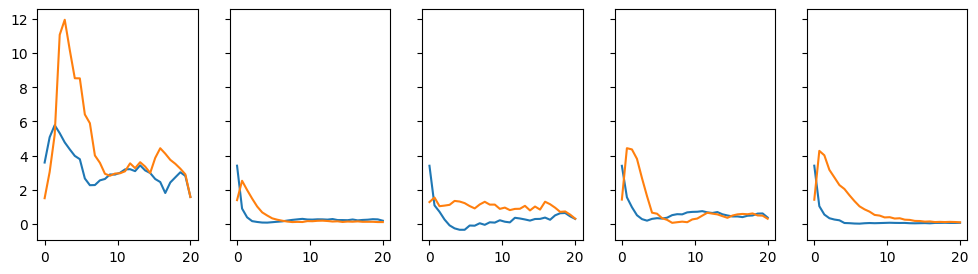

In [9]:
decoder_params = trainer.state.params['decoder']
key = jax.random.PRNGKey(rnd.randint(0, 9999))
z_rng, c_rng, init_rng = random.split(key, 3)
z = random.normal(z_rng, (50, 8))
decoder = CNNDecoder(conv_features=[6,1], conv_kernel_size=[[3,2],[4,1]],hidden_dim=10, decoder_reshape=(12,1,8), out_channel=1, conv_stride=[(1,1),(2,1)], conv_activation=nn.tanh)

c = jax.random.uniform(c_rng, shape=(50,4))
z_c = jnp.concatenate([z, c], axis=-1)
out = decoder.apply({'params': decoder_params}, z_c)             

fig, axs = plt.subplots(1,5, sharex=True, sharey=True, figsize=(12,3))
for i in range(5):
    axs[i].plot(time_train[i], out[i,:,0,:],label='prey')
    axs[i].plot(time_train[i], out[i][:,1,:], label='predator')

plt.show()